**3D fitting**

We use the dataset produced by the data_preparation_HESS.

Objective: how to build a SkyModel and fit it on the data to determine the morphology and spectral shape of the source.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys, logging
import gammapy
import numpy as np
import astropy
import astropy.io.fits as pyfits
#from astropy.io import fits
import regions

from pathlib import Path
from scipy.stats import norm,chi2
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from regions import read_ds9, CircleSkyRegion,RectangleSkyRegion

from gammapy.data import DataStore
from gammapy.analysis import Analysis, AnalysisConfig

from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
    MapDatasetOnOff,
    MapDataset
)
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    Model, 
    Models,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    DiskSpatialModel,
    TemplateSpatialModel,
    Model
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    MapDatasetMaker,
    FoVBackgroundMaker
    )
from gammapy.modeling import Fit
from gammapy.estimators import FluxPoints,FluxPointsEstimator,ExcessMapEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.catalog import CATALOG_REGISTRY

import scipy
log = logging.getLogger(__name__)

In [2]:
# path for the files : codes, xml, reg...
files_path = "/home/pchambery/These_Oct_Mars_2020/hessJ1825_map5X5/gammapy_hessJ1825/"

In [3]:
# Read dataset from disk:  the result of the data reduction, a stacked MapDataset
filename = "/mnt/hgfs/dataset/hess/hessJ1825_dataset_05-20/hessJ1825-hap_fr_he_stacked_normtilt.fits.gz"
stacked = MapDataset.read(filename)

In [4]:
print(stacked)

MapDataset
----------

  Name                            : s4fpx8Z3 

  Total counts                    : 476324 
  Total background counts         : 429295.62
  Total excess counts             : 47028.38

  Predicted counts                : 429295.66
  Predicted background counts     : 429295.62
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+02 m2 s
  Exposure max                    : 5.31e+11 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 761929 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [5]:
position = SkyCoord.from_name("HESS J1825-137")
geom = stacked._geom

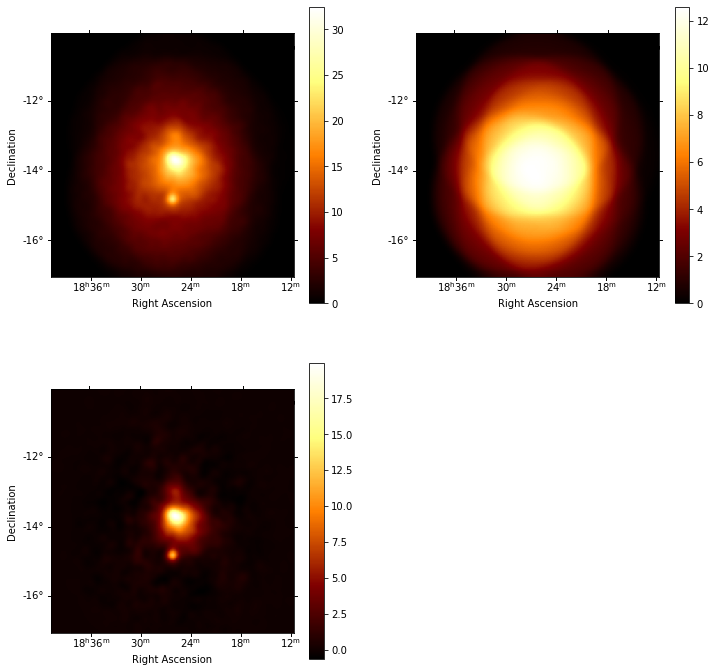

In [6]:
# check data
# plot total counts, background and residuals taking into account the stacked normalized backgrounds
plt.figure(figsize=(12,12))
ax1=plt.subplot(221, projection=stacked.counts.geom.wcs)
stacked.counts.sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax1,  add_cbar=True) # smoothing in 
#stacked.counts.sum_over_axes().plot(ax=ax1,  add_cbar=True) # no smoothing in counts
ax2=plt.subplot(222, projection=stacked.counts.geom.wcs)
stacked.background.sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax2,  add_cbar=True)
ax3=plt.subplot(223, projection=stacked.counts.geom.wcs)
residuals = stacked.residuals().sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax3, add_cbar=True)

In [7]:
# First two energy bins are below the safe threshold defined in the data reduction step.
# To avoid any problem just above the threshold, we remove the third energy bin by defining a fit mask.
# Convert the numpy array into a map
#mask_data_1 = stacked.counts.geom.energy_mask(2.0*u.TeV, 100.0 *u.TeV)
#mask_energy = Map.from_geom(geom=stacked.counts.geom, data=mask_data_1)

# exclusion mask with a ds9 file to not fit certain sources
# Convert the numpy array into a map
excluded_regions = read_ds9(files_path + 'LS5039_box1_maskexclusion_hap-fr-he_ds9.reg')
mask_data_2 = geom.region_mask(excluded_regions, inside=False)
exclusion_mask = Map.from_geom(geom=geom, data=mask_data_2)

# total mask
#full_mask = mask_energy * exclusion_mask
#stacked.mask_fit = full_mask
stacked.mask_fit = exclusion_mask
#stacked.mask_fit = mask_energy

print(stacked)

MapDataset
----------

  Name                            : s4fpx8Z3 

  Total counts                    : 476324 
  Total background counts         : 429295.62
  Total excess counts             : 47028.38

  Predicted counts                : 429295.66
  Predicted background counts     : 429295.62
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+02 m2 s
  Exposure max                    : 5.31e+11 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 710108 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [8]:
print(stacked.models)

None


## First perform background and hessJ1826 fit

In [9]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

In [10]:
bkg_model.spectral_model.norm.value

1.0

In [11]:
bkg_model.spectral_model.tilt.value

0.0

In [12]:
# frees bkg parameters to fit them
bkg_model.spectral_model.norm.frozen = False
bkg_model.spectral_model.tilt.frozen = False

In [13]:
# source : hessJ1826, nearest neighbor extended
spatial_model_hessJ1826 = GaussianSpatialModel(
    lon_0="276.50 deg", lat_0="-13.03 deg", sigma="0.17 deg", frame="icrs"
)

spectral_model_hessJ1826 = PowerLawSpectralModel(
    amplitude=6.66e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.20,
    reference=1.0 * u.Unit("TeV"),
)

model3 = SkyModel(
    spatial_model=spatial_model_hessJ1826,
    spectral_model=spectral_model_hessJ1826,
    name="hessJ1826",
)

In [14]:
# Add the source model to the list of models on the dataset
models = Models([model3, bkg_model])
stacked.models = models

In [15]:
# Freeze hessJ1826 parameters
spatial_model_hessJ1826.lon_0.frozen = True
spatial_model_hessJ1826.lat_0.frozen = True
spatial_model_hessJ1826.sigma.frozen = True

spectral_model_hessJ1826.amplitude.frozen = False
spectral_model_hessJ1826.amplitude.min = 0
spectral_model_hessJ1826.amplitude.max = 1e-10
spectral_model_hessJ1826.index.frozen = True
spectral_model_hessJ1826.reference.frozen = True

In [16]:
%%time
fit = Fit([stacked])

CPU times: user 45 µs, sys: 6 µs, total: 51 µs
Wall time: 54.8 µs


In [17]:
result_1 = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.986E+05               |      Ncalls=68 (68 total)      |
| EDM = 6.63E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


In [18]:
print(result_1)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 68
	total stat : 698629.74



In [19]:
result_1.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,1.2000e+00,,nan,nan,True,0.000e+00
amplitude,5.5266e-13,cm-2 s-1 TeV-1,0.000e+00,1.000e-10,False,2.024e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,2.7650e+02,deg,nan,nan,True,0.000e+00
lat_0,-1.3030e+01,deg,-9.000e+01,9.000e+01,True,0.000e+00
sigma,1.7000e-01,deg,0.000e+00,nan,True,0.000e+00
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00
norm,1.0197e+00,,nan,nan,False,3.766e-03


In [20]:
L1 = stacked.stat_sum()
print(L1)

698629.7350120296


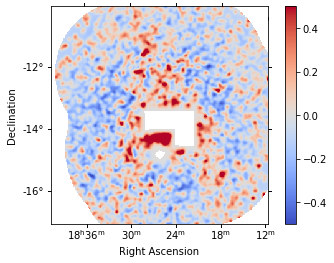

In [21]:
# The residuals maps after the fit
stacked.plot_residuals_spatial(method="diff/sqrt(model)",smooth_radius="0.05 deg",vmin=-0.5,vmax=0.5)

### Define a SkyModel to fit 1 box of HESSJ1825

/home/pchambery/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f289f0d2668>)

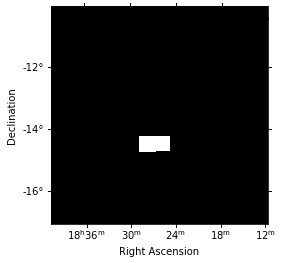

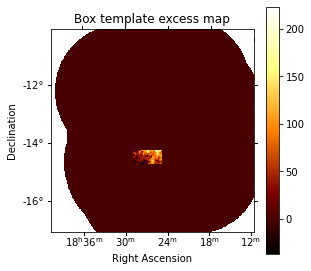

In [22]:
# test : add energy mask
#mask_data_2 = stacked.counts.geom.energy_mask(2.0*u.TeV, 20.0 *u.TeV)
#mask_energy = Map.from_geom(geom=stacked.counts.geom, data=mask_data_2)
#boxenergy_template = mask_energy * box_template

# test : mask on a excess map
estimator_005 = ExcessMapEstimator(correlation_radius=0.05*u.deg)
res_good = estimator_005.run(stacked)
excess_map = res_good["excess"]

# Define the geometry of the Map
energy_axis = stacked.counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()]) # to not have arithmetic pbs, but it is with true energy

# Define the box template and plot it
box_region = read_ds9(files_path + 'box1_template_hap-fr-he_ds9.reg')
#box_template = Map.from_geom(geom=geom, data=template_data)
box_template = Map.from_geom(geom_image)
box_template.data = geom_image.region_mask(box_region, inside=True)
#box_template.sum_over_axes().plot()
box_bool = box_template.sum_over_axes()
box_bool.plot()

# Creation spatial box and plot
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=excess_map.geom.wcs)
ax1.set_title("Box template excess map")
box=excess_map * box_template
box.plot(ax=ax1, add_cbar=True)

# test : mask on residuals map
#residuals = stacked.residuals().sum_over_axes().smooth(0.05 * u.deg).plot(cmap="afmhot", add_cbar=True)

In [23]:
# To save masks to disk
#box_int = box.copy()
box_int = box_bool.copy()
box_int.data = box_int.data.astype(int)
box_int.write("box1_template_hap-fr-he_ds9.fits", overwrite="True")
#box_template_int = box_template.copy()
#box_template_int.data = box_template_int.data.astype(int)
#box_template.write("1box_template_hap-fr-he_ds9.fits", overwrite="True")

In [24]:
# source : hessJ1825 spatial box
box_filename = "1box_template_hap-fr-he_ds9.fits"
box_map = Map.read(box_filename)
spatial_model_hessJ1825_box = TemplateSpatialModel(box_map.sum_over_axes(keepdims=False), normalize=True)
#spatial_model_hessJ1825_box.plot(add_cbar=True)

In [25]:
box_map

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 1)
	ndim  : 3
	unit  : 
	dtype : >i8

In [26]:
# source : hessJ1825 spectral
spectral_model_hessJ1825_box = PowerLawSpectralModel(
    amplitude=4e-13 * u.Unit("cm-2 s-1 TeV-1"), # amplitude for 1 source divided by 6 (for 6 boxes)
    index=1.67,
    reference=1.0 * u.Unit("TeV"),
)

model1 = SkyModel(
    spatial_model=spatial_model_hessJ1825_box,
    spectral_model=spectral_model_hessJ1825_box,
    name="hessJ1825_box",
)

# source : hessJ1826, nearest neighbor extended
spatial_model_hessJ1826 = GaussianSpatialModel(
    lon_0="276.50 deg", lat_0="-13.03 deg", sigma="0.17 deg", frame="icrs"
)

spectral_model_hessJ1826 = PowerLawSpectralModel(
    amplitude=6.66e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.20,
    reference=1.0 * u.Unit("TeV"),
)

model3 = SkyModel(
    spatial_model=spatial_model_hessJ1826,
    spectral_model=spectral_model_hessJ1826,
    name="hessJ1826",
)

In [27]:
models = Models([model1, bkg_model, model3])
stacked.models = models

In [28]:
# Freeze one hessJ1825 box parameters
spectral_model_hessJ1825_box.amplitude.frozen = False
spectral_model_hessJ1825_box.amplitude.min = 0
spectral_model_hessJ1825_box.amplitude.max = 1e-10
spectral_model_hessJ1825_box.index.frozen = False
spectral_model_hessJ1825_box.reference.frozen = True

# Freeze hessJ1826 parameters
spatial_model_hessJ1826.lon_0.frozen = True
spatial_model_hessJ1826.lat_0.frozen = True
spatial_model_hessJ1826.sigma.frozen = True

spectral_model_hessJ1826.amplitude.frozen = False
spectral_model_hessJ1826.amplitude.min = 0
spectral_model_hessJ1826.amplitude.max = 1e-10
spectral_model_hessJ1826.index.frozen = True
spectral_model_hessJ1826.reference.frozen = True

# free the background parameters 
bkg_model.spectral_model.norm.value = 1.0
bkg_model.spectral_model.tilt.value = 0.15

bkg_model.spectral_model.norm.frozen = False
bkg_model.spectral_model.tilt.frozen = False

In [29]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : hessJ1825_box
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   1.670              
    amplitude               :   4.00e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         

Component 1: FoVBackgroundModel

  Name                      : s4fpx8Z3-bkg
  Datasets names            : ['s4fpx8Z3']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt                    :   0.150              
    reference    (frozen)   :   1.000  TeV         

Component 2: SkyModel

  Name                      : hessJ1826
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type    

### Fit the first spectral model

In [30]:
%%time
fit = Fit([stacked])
result_2 = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.982E+05               |     Ncalls=228 (228 total)     |
| EDM = 9.61E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 24.8 s, sys: 1.12 s, total: 25.9 s
Wall time: 26.2 s


In [31]:
print(result_2)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 228
	total stat : 698169.65



In [32]:
result_2.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.1257e+00,,nan,nan,False,6.677e-02
amplitude,2.3817e-12,cm-2 s-1 TeV-1,0.000e+00,1.000e-10,False,2.324e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
norm,1.0146e+00,,nan,nan,False,3.807e-03
tilt,-1.0209e-03,,nan,nan,False,2.790e-03
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
index,1.2000e+00,,nan,nan,True,0.000e+00
amplitude,5.6413e-13,cm-2 s-1 TeV-1,0.000e+00,1.000e-10,False,2.030e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [33]:
L2 = stacked.stat_sum() # stat_sum() give the total likelihood with the current parameters
print(L2)

698169.6525986409


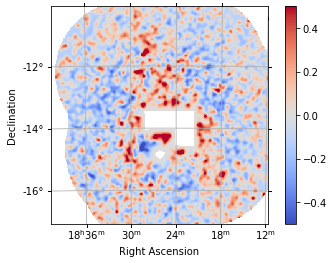

In [34]:
# The residual maps after the fit
stacked.plot_residuals_spatial(method="diff/sqrt(model)",smooth_radius="0.05 deg",vmin=-0.5,vmax=0.5)
plt.grid()

In [35]:
print('TS Detection = ', L1-L2)

TS Detection =  460.0824133887654
